# Supervised Learning with a Parameterized Quantum Circuit 

Note: Recall that supervised learning, a branch of Machine Learning is meant to learning a function that maps an input to an output based on example input-output pairs (data).


Within the course, you have seen the following diagram representing a typical Quantum Machine Learning situation with classical data :

<figure>
  <img src="qml.png" alt="qml">
  <figcaption style="text-align:center">Source: https://dkopczyk.quantee.co.uk/wp-content/uploads/2018/11/outline-768x346.png </figcaption>
</figure>

The quantum circuit is defined by an quantum operator "data preparation" (i.e., the feature map), followed by a operator dependent on real parameters to tweak by classical optimization. We will introduce an example of such situation, showing and explaining each step of the processus.

In [1]:
from scipy.optimize import minimize

import cirq
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

%matplotlib notebook

## I. Get Data

We will generate a random 2D binary classification dataset (points with 1/0 labels inside a given radius) given the following functions.

In [2]:
# Set a random seed
np.random.seed(42)

# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array): array of data points 
        y (array[int]): array of data points labels
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

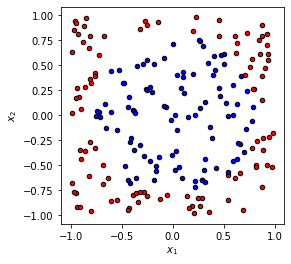

In [3]:
X, Y = circle(200)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X, Y, fig=fig, ax=ax)
plt.show()

## II. Dataset transformation 

Often in Machine Learning, we transform the data before feeding to a model. For instances, adding new features, or filling missing values. More on this topic can be found at https://scikit-learn.org/stable/data_transforms.html

Here, we will add another feature as the product of the x1 and x2 features.

In [4]:
data = np.empty((X.shape[0],X.shape[1]+1))
data[:,:2] = X
data[:,-1] = X[:,0]*X[:,1]

## III. Split into train/validation

In Machine Learning, the goal is to build a model that will generalize well. That means performance should be equivalent on unseen data. One way to train is to split into a training set and a validation set.

In [5]:
data_train, data_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.5, random_state=42, stratify=Y)

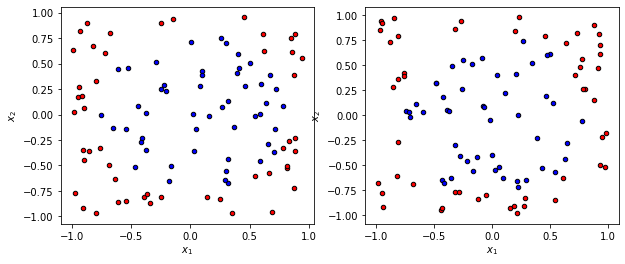

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_data(data_train, Y_train, fig=fig, ax=ax[0])
plot_data(data_test, Y_test, fig=fig, ax=ax[1])
plt.show()

## IV. Setting the model

We will prepare the quantum circuit preparation mapping input-output pairs. 

### 1. Set a few hyperparameters 

We will work on 3 qubits and in a noiseless environment. 
n_layers is for the number of times we will apply the parameterized circuit $U(\theta)$.
If n_measurements is specified as 0, we will use the amplitudes of the final state as the output.
Otherwise, you will use the results after measurements.

In [7]:
n_qubits = 3
n_layers = 5
n_measurements = 0

# Create a register of qubits
qubits = cirq.LineQubit.range(n_qubits)   

# Initialize simulator
simulator = cirq.Simulator()

# initial parameters 
n_params = n_qubits * n_layers

np.random.seed(42)
theta0 = np.random.uniform(-2*np.pi, 2*np.pi, size=n_params)

print("Number of parameters to optimize: ",n_params)

Number of parameters to optimize:  15


### 2. Create the function yielding the circuit

We will set the data preparation circuit to be a layer of RZ-RY-RZ operations and input the data as angles of the layer.

For the parameterized circuit, we will use a layer of RX rotation followed by an entangling layer of CZs. 

In [8]:
def data_preparation(x_i):
    
    # input x_i as angles of RY operations
    yield (cirq.ops.Rz(x_i[j]).on(qubits[j]) for j in range(len(x_i)))
    yield (cirq.ops.Ry(x_i[j]).on(qubits[j]) for j in range(len(x_i)))
    yield (cirq.ops.Rz(x_i[j]).on(qubits[j]) for j in range(len(x_i)))

def pqc(params):
    
    for l in range(n_layers):
        yield (cirq.ops.Rx(params[(l+1)*j]).on(qubits[j]) for j in range(n_qubits))
        yield (cirq.ops.CZ(qubits[j],qubits[j+1]) for j in range(n_qubits-1))
    
    
def qml_classifier_circuit(params, x_i):
    
    if n_measurements > 0:
        return cirq.Circuit(
        data_preparation(x_i),
        pqc(params),
        cirq.measure(*qubits, key='x'))
    else:
        return cirq.Circuit(
        data_preparation(x_i),
        pqc(params))
        
initial_circuit = qml_classifier_circuit(theta0, data[0,:])
print("First instance : ")
print(data[0,:])
print("Divided by pi: ",data[0,:] / np.pi,"\n")

print("Initial params : ")
print(theta0)
print("Divided by pi: ",theta0 / np.pi,"\n")

print(initial_circuit.to_text_diagram(transpose=True))

First instance : 
[-0.25091976  0.90142861 -0.22618625]
Divided by pi:  [-0.07987024  0.28693364 -0.07199732] 

Initial params : 
[-1.57657536  5.66384302  2.91532185  1.23977908 -4.32259725 -4.32290035
 -5.55328511  4.60150516  1.27064871  2.61471713 -6.02451292  5.90506136
  4.17759743 -3.61485335 -3.99830538]
Divided by pi:  [-0.50183952  1.80285723  0.92797577  0.39463394 -1.37592544 -1.37602192
 -1.76766555  1.46470458  0.40446005  0.83229031 -1.91766202  1.87963941
  1.32977056 -1.15064356 -1.27270013] 

0           1           2
│           │           │
Rz(-0.08π)  Rz(0.287π)  Rz(-0.072π)
│           │           │
Ry(-0.08π)  Ry(0.287π)  Ry(-0.072π)
│           │           │
Rz(-0.08π)  Rz(0.287π)  Rz(-0.072π)
│           │           │
Rx(-0.502π) Rx(1.803π)  Rx(0.928π)
│           │           │
@───────────@           │
│           │           │
Rx(-0.502π) @───────────@
│           │           │
│           Rx(0.928π)  Rx(-1.376π)
│           │           │
@───────────@      

### 3. Specify the output for binary classification

We will do many measurements when running the circuit. To associate a probability to predict 1, we will take the probability of outputing the bitstring with only 1s. That means, if the output of the parameterized circuit is a quantum state $\psi_{x_i,\theta}$, we have:
$$ p(x_i = 1) = |\langle 111 | \psi_{x_i,\theta} \rangle|^2 $$

which, when we do many measurements,  is estimated by giving the frequence of the bitstring with all bits equal 1, divided by the number of measurements.

In [9]:
def run_without_measurements(circuit):
    results = simulator.simulate(circuit)
    return abs(results.final_state[-1])

def run_with_measurements(circuit):
    results = simulator.run(circuit, repetitions=n_measurements)
    counter_measurements = results.histogram(key='x')
    probability_being_1 = 0.
    if 7 in counter_measurements.keys():
        probability_being_1 = float(counter_measurements[7]) / n_measurements
    return probability_being_1

def run_circuit(params, x_i):
    
    circuit = qml_classifier_circuit(params,x_i)
    
    if n_measurements > 0:
        probability_being_1 = run_with_measurements(circuit)
    else:
        probability_being_1 = run_without_measurements(circuit)
    return probability_being_1    
        
    
run_circuit(theta0, data[0,:])

0.0077321352

### 4. Set the loss function to optimize

Our circuit will take data rows one by one. After sweeping the entire dataset, one has to define a loss function, characterizing the learning performance of our model. We will use the square loss, which will be our cost passed to a classical optimizer.

In [10]:
def sweep_data(params,X):
    
    probas = [run_circuit(params,X[i,:]) for i in range(X.shape[0])]
    return probas

def compute_loss(params, X, labels):
    predictions = sweep_data(params,X)
    return mean_squared_error(labels, predictions)

# will save by iterations the current cost, and accuracies
tracking_cost = []


def cost_to_optimize(params):
    cost = compute_loss(params, data_train, Y_train)
    tracking_cost.append(cost)
    return cost


## IV. Learning

Now is the time to optimize the parameters of the model for classification. We will use a simple derivative-free optimizer from scipy.

In [11]:
from time import time
start_time = time()
final_params = minimize(cost_to_optimize,theta0,method="COBYLA",options={"maxiter":80})
end_time = time()
print(end_time-start_time)

32.46814274787903


In [12]:
final_params

     fun: 0.17432712074953746
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 80
  status: 2
 success: False
       x: array([-1.35375219,  6.52793509,  4.19245231,  1.28112633, -3.76285872,
       -4.38606526, -6.46510572,  4.54199861,  1.39333321,  2.69138756,
       -5.80072732,  5.84681918,  4.23858995, -3.5551252 , -3.98503786])

## V. Performances

Let us see the accuracy performance by setting the predict function, converting probabilities to binary labels.

In [13]:
def predict(params,X):
    probas = sweep_data(params,X)
    return np.array([1 if p > .5 else 0 for p in probas])

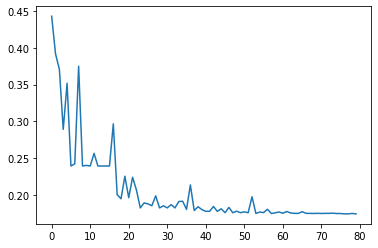

In [14]:
plt.plot(list(range(len(tracking_cost))), tracking_cost)
plt.show()

In [15]:
# before training

print("Accuracy on training set: ", accuracy_score(Y_train,predict(theta0,data_train)))
print("Accuracy on validation set: ", accuracy_score(Y_test,predict(theta0,data_test)))

Accuracy on training set:  0.5
Accuracy on validation set:  0.51


In [16]:
# after training

print("Accuracy on training set: ", accuracy_score(Y_train,predict(final_params.x,data_train)))
print("Accuracy on validation set: ", accuracy_score(Y_test,predict(final_params.x,data_test)))

Accuracy on training set:  0.94
Accuracy on validation set:  0.92


You may have different results at each run. Normally, one should improve the results. There are many ways to do so (more optimization steps, better optimizer, different circuit architecture...).

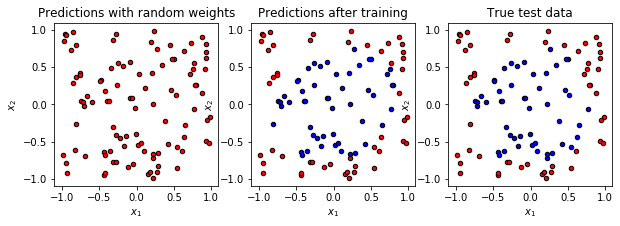

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(data_test, predict(theta0,data_test), fig, axes[0])
plot_data(data_test, predict(final_params.x,data_test), fig, axes[1])
plot_data(data_test, Y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.show()

References:

https://pennylane.ai/qml/app/tutorial_data_reuploading_classifier.html

https://cirq.readthedocs.io/en/stable/tutorial.html

https://github.com/Qiskit/qiskit-aqua/blob/master/qiskit/aqua/components/variational_forms/ry.py